In [1]:
import os
import time

import dill
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from src.mymetrics import MyMetrics
from src.ppi import PPI


def get_project_rootpath():
    """
    获取项目根目录。此函数的能力体现在，不论当前module被import到任何位置，都可以正确获取项目根目录
    :return:
    """
    path = os.path.realpath(os.curdir)
    while True:
        for subpath in os.listdir(path):
            # PyCharm项目中，'.idea'是必然存在的，且名称唯一
            if '.idea' in subpath:
                return path
        path = os.path.dirname(path)


os.chdir(get_project_rootpath())

In [2]:
EMB_ROOT_PATH = 'data/emb/'
PPI_PATH = 'data/network/PPI-Network.txt'
GENECOUNT_PATH = 'data/genecount.xls'
NODE2VEC_EMB_ROOT_PATH = os.path.join(EMB_ROOT_PATH, 'node2vec')

ppi = PPI(ppi_network_path=PPI_PATH, gene_count_path=GENECOUNT_PATH, k=6)

In [22]:



def dataloader_node2vec(emb_path, file_name, positive_gene, risklevel):
    data = file_name.strip('.emb').split('_')
    param = {i[0]: i[1:] for i in data[1:]}

    # 训练特征和label
    file_path = os.path.join(emb_path, file_name)
    with open(file_path, 'r') as f:
        data = [line.strip().split() for line in f.readlines()[1:]]
    X = [line[1:] for line in data]
    target = [1 if int(line[0]) in positive_gene else 0 for line in data]
    X = np.asarray(X, dtype=float)
    target = np.asarray(target, dtype=int)

    # 权重
    class_weight = compute_class_weight(class_weight='balanced', classes=[0, 1], y=target)
    sample_weights = [risklevel[int(line[0])] * class_weight[1]
                      if int(line[0]) in positive_gene else class_weight[0] for line in data]
    return param, X, target, sample_weights

In [20]:
ppi = PPI(ppi_network_path=PPI_PATH, gene_count_path=GENECOUNT_PATH, k=6)
datasets = os.listdir(NODE2VEC_EMB_ROOT_PATH)
models = {}
result_acc = {}
result_f1 = {}
result_auc = {}
result_aupr = {}
step = 1

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 1550,
    'learning_rate': 0.01,
    'max_depth': 6,
    'min_child_weight': 5,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'seed': 420
}

for dataset in datasets:
    start_time = time.time()

    params, X, y, weight = dataloader_node2vec(NODE2VEC_EMB_ROOT_PATH, dataset, ppi.positive_id, ppi.risk_level)
    print(f"Iteration {step} params: p:{params['p']}, q:{params['q']}")
    X_train, X_test, y_train, y_test, weight_train, weights_test = train_test_split(X, y,
                                                                                    weight,
                                                                                    test_size=0.3)
    classifier = xgboost.XGBClassifier(**xgb_params)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_score = classifier.predict_proba(X_test)[:, 1]

    metric = MyMetrics(y_test, y_pred)
    acc, f1, auc, aupr = metric.evaluate(y_test, y_pred, y_score)
    result_acc[(params['q'], params['p'])] = acc
    result_f1[(params['q'], params['p'])] = f1
    result_auc[(params['q'], params['p'])] = auc
    result_aupr[(params['q'], params['p'])] = aupr
    # save the trained model
    model_name = f"{params['q']}_{params['p']}"
    models[model_name] = classifier

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken: {time_taken} seconds")
    print(f"f1:{f1:.4f}, auc:{auc:.4f}, acc:{acc:.4f}, aupr:{aupr:.4f}\n")
    step += 1

# save all models in a file
with open("model/node2vec_all_models.pkl", "wb") as f:
    dill.dump(models, f)

Iteration 1 params: p:2.0, q:2.0
Time taken: 85.15961718559265 seconds
f1:0.7135, auc:0.7647, acc:0.6926, aupr:0.7519

Iteration 2 params: p:2.0, q:0.5
Time taken: 78.44836902618408 seconds
f1:0.7172, auc:0.7741, acc:0.7004, aupr:0.7672

Iteration 3 params: p:2.0, q:4.0
Time taken: 101.81193518638611 seconds
f1:0.7085, auc:0.7646, acc:0.6894, aupr:0.7522

Iteration 4 params: p:2.0, q:1.0
Time taken: 91.9674141407013 seconds
f1:0.7242, auc:0.7746, acc:0.7041, aupr:0.7681

Iteration 5 params: p:0.25, q:0.25
Time taken: 79.17096304893494 seconds
f1:0.7150, auc:0.7694, acc:0.6937, aupr:0.7691

Iteration 6 params: p:0.5, q:2.0
Time taken: 83.80633807182312 seconds
f1:0.7180, auc:0.7716, acc:0.6982, aupr:0.7562

Iteration 7 params: p:4.0, q:1.0
Time taken: 76.73129796981812 seconds
f1:0.7249, auc:0.7795, acc:0.7038, aupr:0.7762

Iteration 8 params: p:2.0, q:0.25
Time taken: 76.32741284370422 seconds
f1:0.7198, auc:0.7799, acc:0.7030, aupr:0.7747

Iteration 9 params: p:0.5, q:4.0
Time taken: 

In [59]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def heatmap_analysis(data_dict):
    # 提取唯一的k1和k2值
    p_values = sorted(set(k1 for k1, k2 in data_dict.keys()))
    q_values = sorted(set(k2 for k1, k2 in data_dict.keys()))

    # 创建空的二维数组
    data_array = np.zeros((len(p_values), len(q_values)))

    # 将字典数据填充到二维数组中
    for i, k1 in enumerate(p_values):
        for j, k2 in enumerate(q_values):
            data_array[i, j] = data_dict.get((k1, k2), 0.0)

    # 创建Seaborn热力图
    sns.set_palette("hls")
    sns.heatmap(data_array)

    # 设置x轴和y轴标签
    plt.ylabel('p')
    plt.xlabel('q')
    plt.xticks(np.arange(len(q_values)) + 0.5, q_values)
    plt.yticks(np.arange(len(p_values)) + 0.5, p_values)

    # 显示图形
    plt.show()

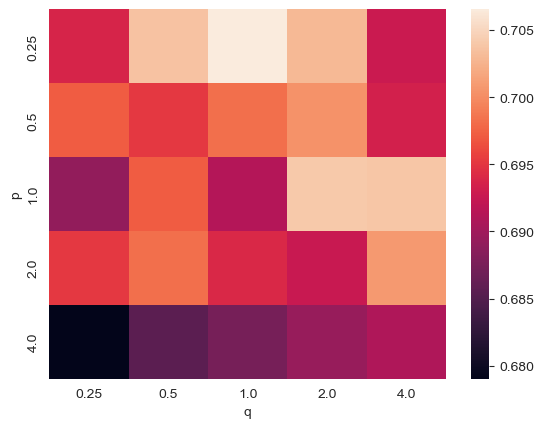

In [60]:
heatmap_analysis(result_acc)

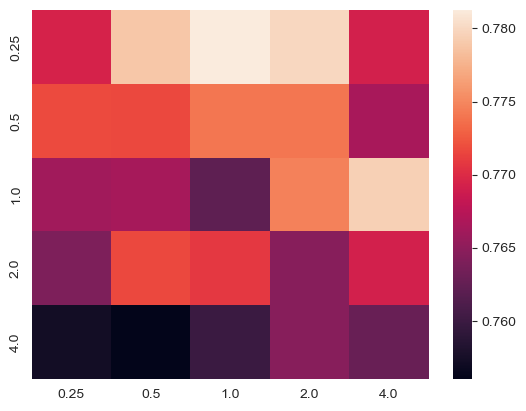

In [50]:
heatmap_analysis(result_auc)

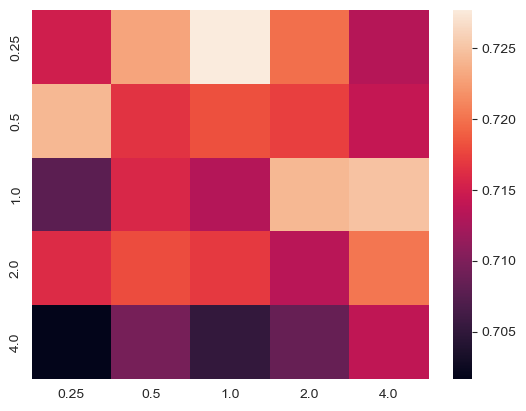

In [51]:
heatmap_analysis(result_f1)

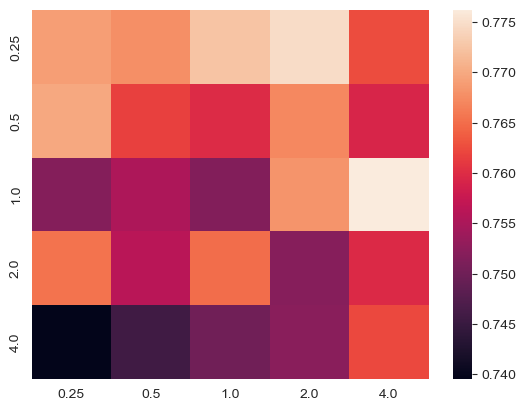

In [52]:
heatmap_analysis(result_aupr)

In [61]:
with open('log/result_node2vec.pkl','wb') as f:
    dill.dump(result_acc,f)
    dill.dump(result_aupr,f)
    dill.dump(result_f1,f)
    dill.dump(result_auc,f)